# This notebook will run stats and averaging of theta dominant frequency

### It depends on the data structure generated by 'Compute_dominant_frequency.ipynb', located in ''../Results/log_welch.npy''

In [14]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter
from scipy import stats 

## time_frequency
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

# Load study related info

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

# Load theta dominant frequency data

In [51]:
# log_welch = np.load('../Results/log_welch.npy',encoding='latin1')
log_welch = np.load('../Results/log_welch_0_1500_4_28_15_2.npy',encoding='latin1')

# The big model : 
### dataframe with all subjects data

In [270]:
log_wel_all = []

for ss in range(len(log_welch)):
    
    for tt in range(len(log_welch[ss])):
        
        log_wel_all.append( [ ss, log_welch[ss][tt][1] , log_welch[ss][tt][2] , log_welch[ss][tt][3] , log_welch[ss][tt][4] ] )
        
        
log_wel_all = np.array(log_wel_all)

In [271]:
log_wel_all = pd.DataFrame(log_wel_all, columns=['sub','density','speed','cuesec','freq'] )

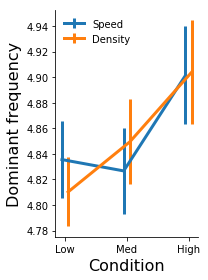

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)


mmd = log_wel_all.groupby(['density']).mean()['freq']
mms = log_wel_all.groupby(['speed']).mean()['freq']

ssd = log_wel_all.groupby(['density']).sem()['freq']
sss = log_wel_all.groupby(['speed']).sem()['freq']

plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)
plt.legend( frameon=False, loc='upper left')

plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)

plt.xticks(range(3), ['Low','Med','High'])

plt.tight_layout()

# plt.savefig('../Figures/theta_dominant_freq_both.pdf')

Pearson:  (0.0914395082034596, 0.009218260280762688)
               sum_sq     df         F    PR(>F)
freq        77.593999    1.0  6.812799  0.009218
Residual  9202.670861  808.0       NaN       NaN


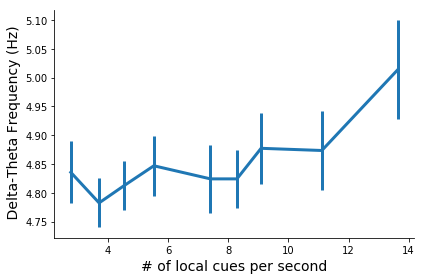

In [130]:
mmcs = log_wel_all.groupby(['cuesec']).mean()['freq']
sscs = log_wel_all.groupby(['cuesec']).sem()['freq']


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)


ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('# of local cues per second', fontsize=14)

plt.tight_layout()


print( 'Pearson: ',  stats.pearsonr(log_wel_all.cuesec, log_wel_all.freq ))

cw_lm=ols('cuesec ~ freq', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')

In [140]:

stats.friedmanchisquare(    )

ValueError: Less than 3 levels.  Friedman test not appropriate.

In [205]:
cw_lm=ols('freq ~ density+speed', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=3))

                sum_sq     df             F    PR(>F)
Intercept  4616.883041    1.0  14717.528555  0.000000
density       1.181482    1.0      3.766284  0.052644
speed         0.583405    1.0      1.859758  0.173033
Residual    253.155589  807.0           NaN       NaN


In [227]:
real_control = 'control'


all_control = []


for iix in range(100):

    save_freq_in_cs =[]
    for cs in log_wel_all.cuesec.unique():
        idx = np.where( log_wel_all.cuesec==cs )[0]
        if real_control == 'control':
            idx = np.random.randint( 0, log_wel_all.shape[0], idx.size  )
        save_freq_in_cs.append( log_wel_all.freq[idx] )





    if real_control == 'real':
        rmm,rss = [],[]
        for ii in range(len(save_freq_in_cs)):    
            rmm.append(np.mean(save_freq_in_cs[ii]))
            rss.append(stats.sem(save_freq_in_cs[ii]))

    if real_control == 'control':
        control_mm,control_ss = [],[]
        for ii in range(len(save_freq_in_cs)):    
            control_mm.append(np.mean(save_freq_in_cs[ii]))
            control_ss.append(stats.sem(save_freq_in_cs[ii]))

        all_control.append(control_mm)
        
all_control = np.array(all_control)




control_m = np.mean(all_control,axis=0)
control_s = stats.sem(all_control,axis=0)


Pearson:  (0.0914395082034596, 0.009218260280762688)
               sum_sq     df         F    PR(>F)
freq        77.593999    1.0  6.812799  0.009218
Residual  9202.670861  808.0       NaN       NaN


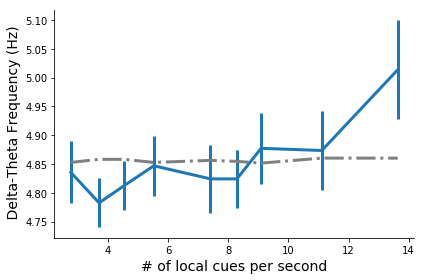

In [277]:
mmcs = log_wel_all.groupby(['cuesec']).mean()['freq']
sscs = log_wel_all.groupby(['cuesec']).sem()['freq']


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)



plt.plot(uni, control_m, linestyle='-.', color='grey', linewidth=3 )
ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3  )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel(' Delta-Theta Frequency (Hz)', fontsize=14)
plt.xlabel('# of local cues per second', fontsize=14)

plt.tight_layout()


print( 'Pearson: ',  stats.pearsonr(log_wel_all.cuesec, log_wel_all.freq ))

cw_lm=ols('cuesec ~ freq', data=log_wel_all).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')

In [316]:
# log_wel_all =  log_wel_all.to_numpy()
normed_freqs = []
for ss in np.arange(8).astype(float):
    idx = np.where(log_wel_all[:,0]==ss)[0]
    
    min_mean = log_wel_all[idx,4][  np.where(log_wel_all[idx,3] == log_wel_all[idx,3].min())[0] ].mean()
    
    tmp = log_wel_all[idx,4] #- min_mean
    cuesecss = log_wel_all[idx,3]
    
    
    tmp_normed_freqs = []
    for cuesec in np.unique(log_wel_all[:,3]):
        
        idx = np.where( cuesecss == cuesec )[0]
        tmp_normed_freqs.append( np.median(tmp[idx])  )
        
        
    normed_freqs.append(tmp_normed_freqs)


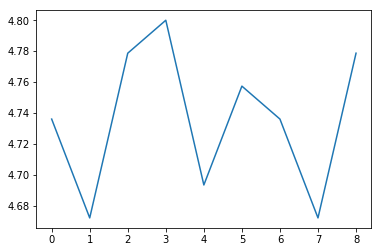

In [317]:
mmm = np.mean(normed_freqs,axis=0)
sss = stats.sem(normed_freqs,axis=0)

plt.plot(mmm)

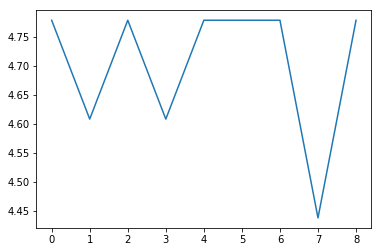

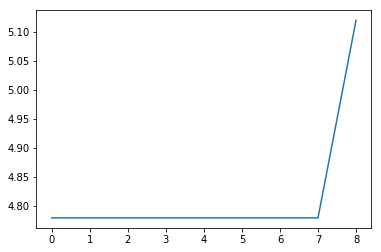

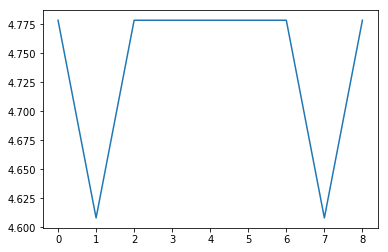

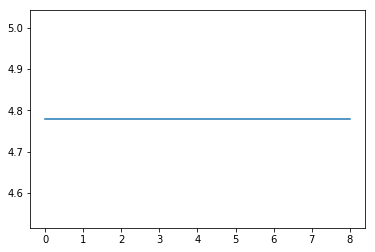

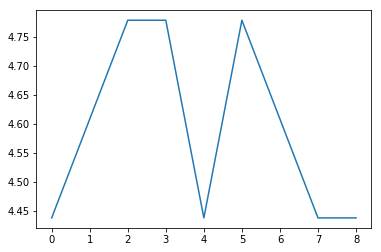

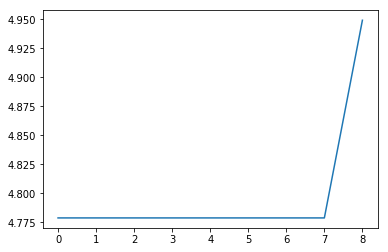

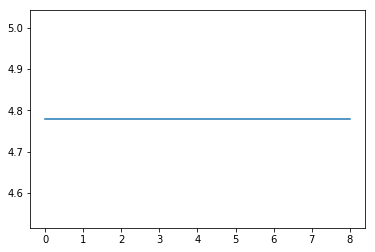

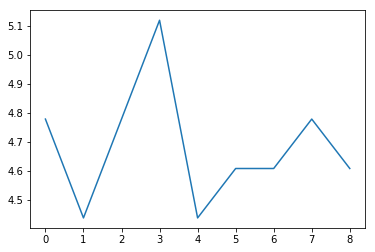

In [320]:

# plt.plot(  np.tile(np.arange(9),8) , np.array(normed_freqs).flatten()  )
for ii in range(len(normed_freqs)):
    plt.plot(normed_freqs[ii])
    plt.show()